# BiSeSAM - Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on harnessing the power of pretrained ViT image encoder from META's Segment Anything Model SAM.
We explore a combination of different custom decoders, we name this model architecture BiSeSAM. BiSeSAM will be finetuned on Satellite Images for Street Segmentation. (BiSeSAM - Binary Semantic SAM)

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Skip Connection MLP
4. Spatially Aware MLP

For more details please read our [report](BiSeSAM.pdf)

In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###### KAGGLE DATA SET #####
kaggle_data = {}
kaggle_data["images"] =load_training_images()
kaggle_data["masks"] = load_groundtruth_images()

######## EPFL DATA SET #####
epfl_data = {}
epfl_data["images"] = load_training_images("EPFL")
epfl_data["masks"] = load_groundtruth_images("EPFL")


####### CUSTOM GOOGLE MAPS DATA SET #####
city_names = ["boston","nyc","philadelphia","austin"]
gmaps_data = {"images":[],"masks":[]} # stores images and gt masks
for name in city_names:
    gmaps_data["images"].extend(load_training_images(name))
    gmaps_data["masks"].extend(load_groundtruth_images(name))
assert (len(gmaps_data["images"]) == len(gmaps_data["masks"]))


######## PRINT GOOGLE MAPS DS STATISTICS ########
print("the raw custom dataset contains",len(gmaps_data["images"]),"images")
print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(gmaps_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(kaggle_data["masks"]))
print("custom ds with ignore under threshold: (min,mean,max) street ratio",get_street_ratio_mmm(gmaps_data["masks"],min_ratio_threshold=0.03))



##############
gmaps_data_set = Sat_Mask_Dataset(gmaps_data["images"], gmaps_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
kaggle_data_set  = Sat_Mask_Dataset(kaggle_data["images"],kaggle_data["masks"])
epfl_data_set = Sat_Mask_Dataset(epfl_data["images"],epfl_data["masks"])

print("after cleanup, the dataset now contains",len(kaggle_data_set),"images")

######## KAGGLE - SUBMISSION DATA SET ########
kaggle_submission_images = load_test_images()
kaggle_submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)

# print num of data in original and custom dataset
print("original dataset contains",len(gmaps_data_set),"images")
print("custom dataset contains",len(kaggle_data_set),"images")


using device: cuda:0
the raw custom dataset contains 12985 images
custom ds: (min,mean,max) street ratio (0.0, 0.13372669666923362, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.177976953125, 0.40426875)
custom ds with ignore under threshold: (min,mean,max) street ratio (0.03005625, 0.14823332153582142, 0.72180625)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.10242587601078167  num discarded: 1330
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 144 images
original dataset contains 11655 images
custom dataset contains 144 images


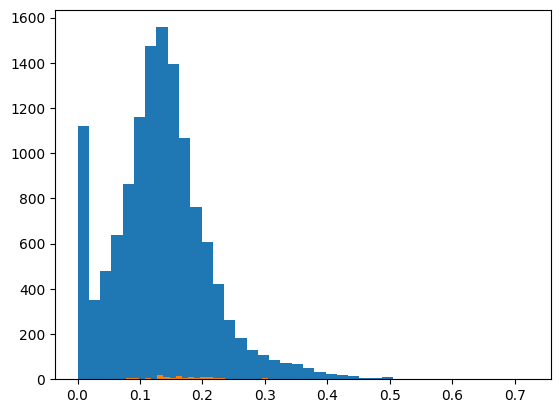

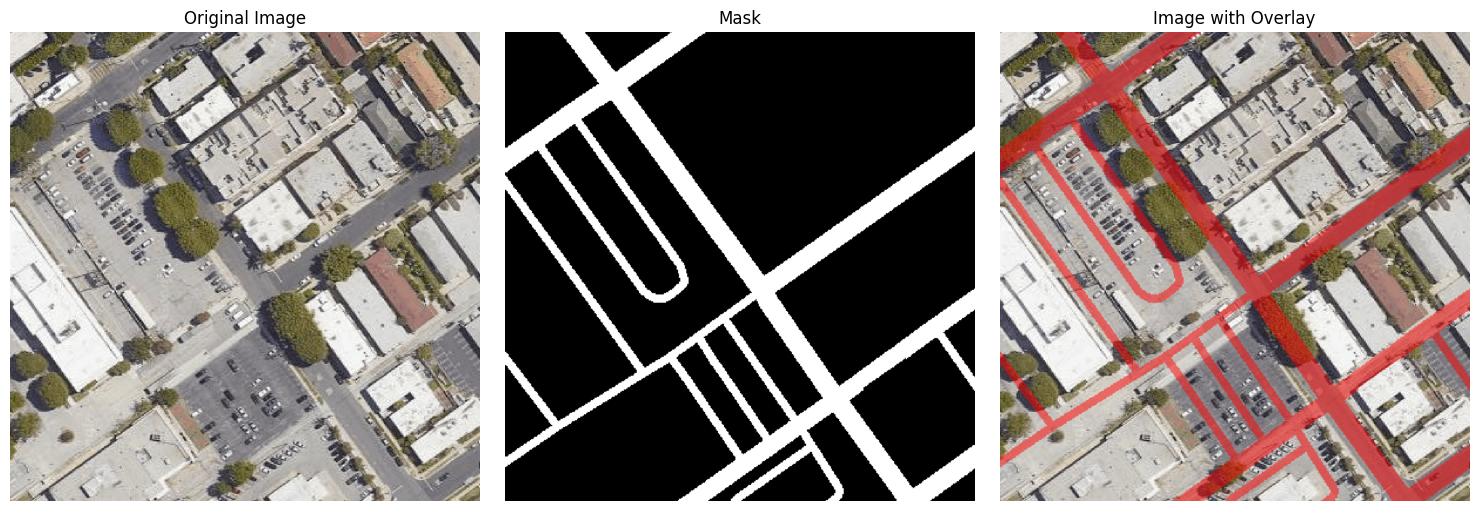

In [3]:
show_sample_images = True
import numpy as np
import matplotlib.pyplot as plt

if show_sample_images:
    
    ######### show distribution of street ratio:
    # plot the street ratio distribution of the dataset
    custom_ratios = get_street_ratio_distr(gmaps_data["masks"])
    original_ratios = get_street_ratio_distr(kaggle_data["masks"])

    plt.hist(custom_ratios,40)
    plt.hist(original_ratios,40)
    plt.show()
    
    # get some random training images
    idx = 4
    image, mask = kaggle_data_set[idx]

    img = np.array(image).astype(np.uint8)
    # swap first and third dimension
    img = np.swapaxes(img, 0, 2)
    mask = np.array(mask)
    mask = np.swapaxes(mask, 0, 2)

    # Create a reddish tone image with the same shape as the original image
    reddish_tone = np.zeros_like(img)
    reddish_tone[..., 0] = 255  # Red channel to maximum

    # Define the opacity for the overlay
    opacity = 0.5

    # Ensure the mask is binary (0 or 255) and has the same shape as the original image
    binary_mask = (mask > 0).astype(np.uint8) * 255

    # Blend the original image and the reddish tone based on the mask
    blended_image = np.where(binary_mask == 255, 
                            (img * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                            img)

    # Display the original image, mask, and blended image side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(blended_image)
    axes[2].set_title('Image with Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


## Dataloader

In [8]:
train_split = 0.8
gpu_batch_size = 1

import torch.utils.data

torch.manual_seed(0)
gen = torch.Generator()
gen.manual_seed(0)


kaggle_train_dataset, kaggle_test_dataset = torch.utils.data.random_split(kaggle_data_set, [train_split, 1-train_split],generator=gen)
gmaps_train_dataset, gmaps_test_dataset = torch.utils.data.random_split(gmaps_data_set, [train_split, 1-train_split],generator=gen)


from torch.utils.data import DataLoader
gmaps_dataloader = DataLoader(gmaps_data_set, batch_size=1, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# kaggle dataloader
kaggle_dataloader = DataLoader(kaggle_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
kaggle_train_dataloader = DataLoader(kaggle_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
kaggle_test_dataloader = DataLoader(kaggle_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)


# dataloader for submission dataset: 
submission_dataloader = DataLoader(kaggle_submission_data_set, batch_size=1, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)



## Loading BiSeSAM

This codes loades BiSeSAM with the various different decoder options. Either from a SAM checkpoint with a randomly initialized decoder or a trained version stored on disk.

In [9]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(encoder_option:int, device,decoder):
    #
    # encoder_option =0 : for vit_b with the encoder that just retunrs the final block output.
    # encoder_option =1 : for vit_b with the encoder that returns the intermediate outputs + final output.  
    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_b_intermediate"]#,"vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth"] #,"sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[encoder_option]](checkpoint=model_paths[0])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder)
    model = model.to(device)
    return model

# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################

def load_sam_model(decoder_option, device, encoder_finetune_num_first_layers,encoder_finetune_num_last_layers,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam",load_from_compiled=False):
    #   
    #   decoder_options: ["conv", "mlp" , "spatial-full", "spatial-small", "skip-connect]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #
    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-full":
        decoder = MLP_Decoder_Spatially_Aware(context_option=1)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-small":
        decoder = MLP_Decoder_Spatially_Aware(context_option=0)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    elif decoder_option == "skip-connect":
        decoder = Skip_MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(1,device,decoder)
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        
        if "custom_segment_anything/model_checkpoints" in finetuned_model_name:
            load_path = finetuned_model_name+".pth"
        else:
            load_path = finetune_path+finetuned_model_name+".pth"
        if load_from_compiled:
            model = torch.compile(model)
        model.load_state_dict(torch.load(load_path,map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers or layer_number < encoder_finetune_num_first_layers:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    #model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Loss Functions

In [10]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

def dice_loss(logits,masks, smooth=1e-6):
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def only_bce(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    return bce_loss(logits_sq, mask_sq)

def combined_loss_dice(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

def get_confusion_values(logits,masks):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    # first reshape the tensors
    pred = torch.round(torch.sigmoid(logits))
    
    tp = torch.sum(pred * masks)
    tn = torch.sum((1 - pred) * (1 - masks))
    fp = torch.sum(pred * (1 - masks))
    fn = torch.sum((1 - pred) * masks)
    return tp,tn,fp,fn
        

# Training Loop - All Decoder Variants

The code goes over all possible decoder versions for BiSeSAM and trains on them on gmaps data according to the training procedure described in the report Appendix and below:

(A,B) means that the A first and B last weights of the image encoder are unfrozen and finetuned. Note that there are in total 176 weights in the 12-block image encoder ViT. Note that always all decoder layers are trained. Batch size=5 and Adam Optimizer are used.

1. 3 Epochs (0,25) with lr = 0.001
2. 3 Epochs (0,65) with lr = 0.0001
3. 4 Epochs (15,85) with lr = [ 0.0001/1 ,  0.0001/2,  0.0001/ 3,  0.0001/ 4]
4. 4 Epochs (25,105) with lr = [ 0.0001/1 ,  0.0001/2,  0.0001/ 3,  0.0001/ 4]

In [ ]:
### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = gmaps_dataloader
test_loader = kaggle_dataloader


########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader)
20
do_intermed_prints = False

#########

decoder_options =  ["conv","spatial-small","spatial-full","skip-connect","mlp"]
num_layers_to_finetune_back = [25,65,85,105]
num_layers_to_finetune_front = [0,0,15,25]
learning_rates = [0.001,0.0001, 0.0001,0.0001]
loss_functions = [only_bce,combined_loss_dice,combined_loss_dice]
max_epochs = [3,3,4,4]
grad_batch_size_choices = [5,5,5,5]

##################################
# TRAINING LOOP
################################

# OPTIMIZATIONS 
mean_f1_score_from_logits = torch.compile(mean_f1_score_from_logits)
loss_fn_idx = 2
# Hyperparameter tuning yielded that we use the loss function BCE + Dice for the best results

loss_fn = loss_functions[loss_fn_idx]
loss_fn = torch.compile(loss_fn)
print("using loss function:",loss_fn)

for decoder_option in decoder_options:
        
    for idx_layer_option in range(len(num_layers_to_finetune_back)):
        # set the max number of epochs for this layer option
        max_num_epochs = max_epochs[idx_layer_option]
        
        for epoch_counter in range(max_num_epochs):
            torch.cuda.empty_cache()
            gc.collect()

            epoch_to_train = epoch_counter
            layer_option_back = num_layers_to_finetune_back[idx_layer_option]
            layer_option_front = num_layers_to_finetune_front[idx_layer_option]
            
            # if the layer_option is larger than 1 (i.e. if at least 85 layers in the back are tuned, reduce lr.), reduce lr 
            learning_rate = learning_rates[idx_layer_option]
            if idx_layer_option >= 2:
                learning_rate = learning_rate / (epoch_counter + 1)
                print("divided lr")
            print("using lr:",learning_rate)
            #loss_fn = loss_functions[loss_fn_idx]
            #print("using loss function:",loss_fn)
            grad_batch_size = grad_batch_size_choices[loss_fn_idx]
            
            #####################################            
            # now training this model 
            current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter}"
            print("training model:",current_model_description)
            # check if this current model description already exists, if so, load the model and skip this exact training step:
            if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                print("model already exists, skipping training for this layer option")
                continue
            # since model was not already trained
            # load the "start model from checkpoint or finetuned"
            # load the initial model from the sam checkpoint
            if idx_layer_option == 0 and epoch_counter == 0:
                print("loading model from sam checkpoint")
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=None,sam_checkpoint_or_finetuned="sam",load_from_compiled=False)
                model = torch.compile(model)
            else:
                
                if epoch_counter == 0:
                    last_max_epoch = max_epochs[idx_layer_option-1]
                    # now epoch 0, hence load max epoch from previous layer option
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{num_layers_to_finetune_front[idx_layer_option-1]}_{num_layers_to_finetune_back[idx_layer_option-1]}_epoch_{last_max_epoch-1}"
                else:
                    # load the last epoch from current layer option
                    
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter-1}"
                print("loading model from finetuned:",model_description)
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
                
            # newly initializing the optimizer and scheduler since model was loaded new (do this for every epoch:)
            ####################################
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            print("Starting Epoch: ",epoch_counter)
            # training run: 
            model.train()
            # store running losses for the epoch and the 10% print interval
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0

            short_running_loss = 0.0
            short_running_f1 = 0.0

            step_counter = 0
            
            # reset the gradients: 
            optimizer.zero_grad()
            
            #########################################
            # TRAINING LOOP
            for image, mask in tqdm(train_loader):
                step_counter += 1
                #####################
                # forward pass
                image = image.to(device)
                mask = mask.to(device)    
                pred = model(image)
                # compute loss and f1 score: 
                loss = loss_fn(pred,mask)
                
                
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                short_running_loss += loss.item()
                short_running_f1 += f1_score

                loss.backward()

                ###############
                # backward pass
                if step_counter % grad_batch_size == 0:
                    # update the model weights
                    optimizer.step()
                    # reset the gradients
                    optimizer.zero_grad()
                
                if do_intermed_prints and step_counter % print_interval == 0:
                    print("step: ",step_counter//print_interval)
                    # print out the current losses:
                    print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                    # and reset the short running losses
                    short_running_loss = 0.0
                    short_running_f1 = 0.0

            print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
            ########################################
            # save the model in every epoch
            print("saving model:",current_model_description)
            torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth")
            #########################################
            
            # testing run: 
            model.eval()
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")
        # save the model after the training run

# Check Pre-Training Performance

Now, check the performance on the kaggle dataset of the last model trained for each decoder.


In [ ]:
print(len(kaggle_dataloader))

In [ ]:
from tqdm import tqdm

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")


decoder_options =  ["conv","spatial-small","spatial-full","skip-connect","mlp"]
## select the dataloader
test_loader = kaggle_dataloader

losses = {}
f1_scores = {}

layers_front = [25] # [0,0,15,25]
layers_back = [105] # [25,65,85,105]
epoch_ranges = [4] # [3,3,4,4]

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)
loss_fn_idx = 2

for decoder_option in decoder_options:
    losses[decoder_option] = []
    f1_scores[decoder_option] = []
    
    for layer_idx in range(len(layers_front)):
        epoch_range = epoch_ranges[layer_idx]
        for epoch_counter in range(epoch_range):
            torch.cuda.empty_cache()
            gc.collect()
            
            l_front = layers_front[layer_idx]
            l_back = layers_back[layer_idx]
            
            model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{l_front}_{l_back}_epoch_{epoch_counter}"
            model_path = "custom_segment_anything/model_checkpoints/finetuned/"+model_description
            compiled = (decoder_option != "mlp") # only the mlp was trained with the non compiled option initially
            model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=model_path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=compiled)
            
            # for each model compute the f1 and loss score of the original dataset
            model.eval()
            
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                    
                mean_f1 = score_acc/len(test_loader)
                mean_loss = l_acc/len(test_loader)
                losses[decoder_option].append(mean_loss)
                f1_scores[decoder_option].append(mean_f1)
                print(f"Decoder: {decoder_option},Loss Function {loss_fn_idx}: Layer_idx: {layer_idx} Epoch: {epoch_counter}, (test) Loss: {mean_loss}, F1-Score: {mean_f1}")
            
# plot the resolts for all loss function in two seperate plots, one for f1 and one for loss

In [ ]:
import matplotlib.pyplot as plt
epoch_sum = sum(epoch_ranges)
epochs = list(range(epoch_sum))

# Plot F1 Scores
plt.figure(figsize=(12, 6))
for decoder_option in decoder_options:
    plt.plot(epochs, f1_scores[decoder_option], label=decoder_option)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for different Decoders')
plt.legend()
plt.show()

# Plot Loss Scores
plt.figure(figsize=(12, 6))
for decoder_option in decoder_options:
    plt.plot(epochs, losses[decoder_option], label=decoder_option)
plt.xlabel('Epoch')
plt.ylabel('weighted BCE+Dice Loss')
plt.title('Loss over Epochs for Different Loss Functions')
plt.legend()
plt.show()

# Figuring out the best finetuning strategy:

for this try out different learning rate and dataset options. Tune for at most 20 epochs, get the scores and validate them in the kaggle submission system

In [ ]:
from tqdm import tqdm

import gc
torch.cuda.empty_cache()
gc.collect()
# ENABLE TF32 compute precision
torch.set_float32_matmul_precision("high")


lr_options = [0.0001,0.00001]

training_options = [kaggle_train_dataloader]
test_options = [kaggle_test_dataloader]

training_desc = ["kaggle"]

# now check only for the best model, the mlp model


max_epochs = 21

train_losses = {}
train_f1_scores = {}
test_losses = {}
test_f1_scores = {}

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)

for lr in lr_options:
    for train_idx in range(len(training_desc)):
        train_loader = training_options[train_idx]
        test_loader = test_options[train_idx]
        
        desc_key = f"lr_{lr}_{training_desc[train_idx]}"
        
        print("now doing: ",desc_key)
        
        train_losses[desc_key] = []
        train_f1_scores[desc_key] = []
        test_losses[desc_key] = []
        test_f1_scores[desc_key] = []
        
        model = load_sam_model("mlp",device,encoder_finetune_num_first_layers=25,encoder_finetune_num_last_layers=105,finetuned_model_name="model_3_mlp_decoder_finetune_last_25_105_epoch_3",sam_checkpoint_or_finetuned="finetuned",load_from_compiled=False)
        model = torch.compile(model)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(max_epochs):
            
            # TRAIN
            torch.cuda.empty_cache()
            gc.collect()
            
            model.train()
            optimizer.zero_grad()
            
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0
            step_counter = 0
            for img,mask in tqdm(train_loader):
                step_counter += 1
                img = img.to(device)
                mask = mask.to(device)
                pred = model(img)
                loss = loss_fn(pred,mask)
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                loss.backward()
                if step_counter % 5 == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # save the results: 
            train_losses[desc_key].append(epoch_running_loss/len(train_loader))
            train_f1_scores[desc_key].append(epoch_running_f1/len(train_loader))    
            
            # save the model at specific intervals: 
            if epoch % 5 == 0:
                model_path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/mlp_{desc_key}_epoch_{epoch}.pth"
                torch.save(model.state_dict(), model_path)
            
            # TEST
            
            model.eval()
            with torch.no_grad():
                epoch_running_loss = 0.0
                epoch_running_f1 = 0.0
                step_counter = 0
                for img,mask in tqdm(test_loader):
                    step_counter += 1
                    img = img.to(device)
                    mask = mask.to(device)
                    pred = model(img)
                    loss = loss_fn(pred,mask)
                    f1_score = mean_f1_score_from_logits(pred,mask).item()
                    epoch_running_loss += loss.item()
                    epoch_running_f1 += f1_score
                    
                # save the results: 
                test_losses[desc_key].append(epoch_running_loss/len(test_loader))
                test_f1_scores[desc_key].append(epoch_running_f1/len(test_loader))    


print("train losses:",train_losses)
print("train f1 scores:",train_f1_scores)
print("test losses:",test_losses)
print("test f1 scores:",test_f1_scores)

In [ ]:
# for each key in test_f1_scores; print the 0,5,10,15,20 epoch results

max_thing = (0,0)
max_val = 0.

for key in test_f1_scores.keys():
    print(f"key: {key}")
    idxs = [0,5,10,15,20]
    for idx in idxs:
        print(f"epoch: {idx}, loss: {test_losses[key][idx]}, f1: {test_f1_scores[key][idx]}")
        if test_f1_scores[key][idx] > max_val:
            max_val = test_f1_scores[key][idx]
            max_thing = (key,idx)
            
print("max thing:",max_thing, "max val:",max_val)

For evaluation reasons I want to submit one model prediction to the kaggle submission system:

lr_1e-05_kaggle, 15, local F1: 94.06 -> Online: 93.253


# Finetune each model with the kaggle data

The finetuning strategy will be

batch_size = 15
run for at most 15 epochs
store for each decoder option, the best achieving f1 and score model seperately.



In [ ]:



### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = kaggle_train_dataloader
test_loader = kaggle_test_dataloader


########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 10
do_intermed_prints = False



#########

decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"]

max_epochs = 15

##################################
# TRAINING LOOP
################################

loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)


for decoder_option in decoder_options:
    
    # load the current model: 
    load_compiled = (decoder_option != "mlp")
    model_description = f"model_3_{decoder_option}_decoder_finetune_last_25_105_epoch_3"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=25,encoder_finetune_num_last_layers=105,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=load_compiled)
    if not load_compiled:
        model = torch.compile(model)
    best_f1 = 0.
    best_loss = 1000.

    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(max_epochs):
    
        torch.cuda.empty_cache()
        gc.collect()

        # training run: 
        model.train()
        # reset the gradients: 
        optimizer.zero_grad()
        
        #########################################
        # TRAINING LOOP
        step_counter = 0
        for image, mask in tqdm(train_loader):
            step_counter += 1
            #####################
            # forward pass
            image = image.to(device)
            mask = mask.to(device)    
            pred = model(image)
            # compute loss and f1 score: 
            loss = loss_fn(pred,mask)
            loss.backward()
            

            ###############
            # backward pass
            if step_counter % 5 == 0:
                # compute the gradients
                # update the model weights
                optimizer.step()
                # reset the gradients
                optimizer.zero_grad()
        
        ####### EVALUATION
        
        
        # testing run: 
        model.eval()
        with torch.no_grad():
            l_acc = 0.0
            score_acc = 0.0
            for image,mask in tqdm(test_loader):
                image = image.to(device)
                mask = mask.to(device)
                pred = model(image)
                # compute loss and f1 score: 
                score = mean_f1_score_from_logits(pred,mask)    
                loss =  loss_fn(pred,mask)
                # update running loss and f1 score
                score_acc += score.item()
                l_acc  += loss.item()
                # store the loss and f1 score
                
            mean_f1 = score_acc/len(test_loader)
            mean_loss = l_acc/len(test_loader)
        
        save_model_description_f1  = f"decoder_{decoder_option}_bestf1.pth"
        save_model_description_loss = f"decoder_{decoder_option}_bestloss.pth"
        file_path = "custom_segment_anything/model_checkpoints/finetuned_kaggle/"
        
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            torch.save(model.state_dict(), file_path+save_model_description_f1)
            print("Decoder option:",decoder_option,"new best f1:",best_f1)
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(model.state_dict(), file_path+save_model_description_loss)
            print("Decoder option:",decoder_option,"new best loss:",best_loss)
            
        #########################################
        
    print("finished training for decoder option:",decoder_option)
    print("best f1:",best_f1, "best loss:",best_loss)    



finished training for decoder option: mlp
best f1: 0.9406011423894337 best loss: 1.4403232016733714

finished training for decoder option: conv
best f1: 0.94107914183821 best loss: 1.443434430020196

finished training for decoder option: spatial-small
best f1: 0.9401421227625438 best loss: 1.4749739553247179

finished training for decoder option: spatial-full
best f1: 0.9409123829432896 best loss: 1.432130630527224

finished training for decoder option: skip-connect
best f1: 0.9407457964760917 best loss: 1.4466931287731444

# Single Model Submission and Rounding Ensemble Submission of best models

In [ ]:

import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)


def ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    all_predictions = []
    for model in model_list:
        model = model.to(device)
        model.eval()
        predictions = []

        with torch.no_grad():
            for image in tqdm(submission_dataloader):
                image = image.to(device)
                pred = model(image)
                predictions.append(pred)
        model = model.to("cpu")
    # check the shape of the predictions
        assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
        all_predictions.append(predictions)
    # go over all predictions and convert the logits to predictions:
    
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    num_models = len(model_list)
    num_images = len(all_predictions[0])
    assert num_images == 144
    
    for img_index in range(num_images):
        
        
        ensemble_image = np.zeros((400,400))
        
        for model_idx in range(num_models):
            pred = all_predictions[model_idx][img_index]
            pred = pred.squeeze()
            # pred is torch vector of shape (1024,1024)
            # convert to image
            pred = torch.round(torch.sigmoid(pred))
            # compress to 400x400
            pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
            #print(pred.shape)
            # pred is now torch vector of shape (1,1,400,400)
            # convert to numpy
            pred = pred.squeeze().squeeze().to("cpu").numpy()
            #print(pred.shape)
            # pred is now numpy vector of shape (400,400)

            # add to initial image
            ensemble_image += pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        if rounding_policy == "up" or rounding_policy == "down":
            ensemble_image = ensemble_image/num_models
        
            # round the image
            if rounding_policy == "up":
                ensemble_image = np.round(ensemble_image)
            elif rounding_policy == "down":
                ensemble_image = np.floor(ensemble_image)
            else:
                raise ValueError("invalid rounding policy")
        elif rounding_policy == "min1":
            ensemble_image[ensemble_image > 1] = 1
            #ensemble_image = np.round(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        # store as png to disk
        ensemble_image = (ensemble_image * 255).astype(np.uint8)
        # add 2 other color channels
        ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold=foreground_threshold)
    
    
    
def ensemble_model_loss_f1(model_list,test_dataloader,rounding_policy="up",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    for model in model_list:
        model = model.to(device)
        model.eval()

    num_models = len(model_list)
    f1_acc = 0.
    
    for image, mask in tqdm(test_dataloader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        ensemble_image = torch.zeros((1,1,1024,1024),device=device)
        
        with torch.no_grad():
            for model in model_list:
                pred = model(image)
                pred = torch.round(torch.sigmoid(pred))
                ensemble_image = ensemble_image + pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        if rounding_policy == "up" or rounding_policy == "down":
            ensemble_image = ensemble_image/num_models
        
            # round the image
            if rounding_policy == "up":
                ensemble_image = torch.round(ensemble_image)
            elif rounding_policy == "down":
                ensemble_image = torch.floor(ensemble_image)
            else:
                raise ValueError("invalid rounding policy")
        elif rounding_policy == "min1":
            ensemble_image[ensemble_image > 1] = 1
            #ensemble_image = np.round(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        
        # compute the f1 score here: 
        
      
        # compute the f1 score
        f1_acc += mean_f1_score_from_classes(ensemble_image,mask)
        
    print("mean f1_score: ",f1_acc/len(test_dataloader))

# Creating Submission for the BiSeSAM decoders

In [ ]:
decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"]

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_to_submission(model,submission_dataloader,submission_filename =  f"decoder_{decoder_option}_submission.csv")

# Majority Vote BiSeSAM Ensemble 

In [ ]:
# create a majority vote ensemble of the models
model_list = []

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_list.append(model)

ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "majority_vote_ensemble_submission.csv",foreground_threshold=0.25)

# compute the loss on the local kaggle test set
ensemble_model_loss_f1(model_list,kaggle_test_dataloader,rounding_policy="up",foreground_threshold=0.25)

# Training an Ensemble of N models

The idea is to concatenate the logit predicitions of all models together, use the sigmoid on them and then feed this information into an mlp, and train this for 1 epoch. This then is the final mlp prediction.:

Please note that the trained ensemble model is extremely specific to the models that were used to train it.

In [ ]:


# now we test these models submission:

# create a majority vote ensemble of the models
decoder_options = ["mlp" ,"conv","spatial-small","spatial-full","skip-connect"] # IMPORTANT IS THE CORRECT ORDER FOR ENSEMBLE TRAIN COMPUTATION/LOADING FROM MEMORY
model_list = []

for decoder_option in decoder_options:
    path = f"custom_segment_anything/model_checkpoints/finetuned_kaggle/decoder_{decoder_option}_bestf1"
    model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name=path,sam_checkpoint_or_finetuned="finetuned",load_from_compiled=True)
    model_list.append(model)


In [ ]:
from tqdm import tqdm
num_models = len(model_list)

######## DEFINE MODEL ########
from custom_segment_anything.segment_anything.CUSTOM_SAM import EnsembleMLP

#gc
import gc
gc.collect()
torch.cuda.empty_cache()
# enable TF32
torch.set_float32_matmul_precision("high")


ensemble_model = EnsembleMLP(num_models)

######### OPTIMIZER AND LOSS FUNCTION ########
loss_fn = combined_loss_dice
loss_fn = torch.compile(loss_fn)
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.0001)

max_num_epochs=10
####### DATA LOADER ##########
train_loader = kaggle_train_dataloader
eval_d_loader = kaggle_test_dataloader


# bring all models to the device

for model in model_list:
    model = model.to(device)

ensemble_model = ensemble_model.to(device)
##############################


for epoch_counter in range(max_num_epochs):

    # go over all models and feed the input image: 

    ensemble_model.train()
    
    ###### TRAINING: #######
    loss_acc = 0.0
    f1_acc = 0.0
    
    step_counter = 0

    for image, mask in tqdm(train_loader):

        image = image.to(device)
        mask = mask.to(device)
        all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(num_models):
                model = model_list[model_idx]

                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
        
        # compute the ensemble prediction
        ensemble_pred = ensemble_model(all_preds).squeeze(4)
        # compute the loss
        #print(ensemble_pred.shape,mask.shape,ensemble_pred.min(),ensemble_pred.max(),mask.min(),mask.max())
        loss = loss_fn(ensemble_pred,mask)
        # backpropagate
        loss.backward()
        optimizer.step()
        loss_acc += loss.item()
        # compute the f1 score
        f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()

    # print the loss and f1 score
    print(f"Epoch {epoch_counter} (train) Loss: {loss_acc/len(train_loader)}, F1-Score: {f1_acc/len(train_loader)}")
     
        

    torch.save(ensemble_model.state_dict(), f"custom_segment_anything/model_checkpoints/ensemble_mlp/ensemble_model_{epoch_counter}.pth")
    
    ###### TESTING: #######
        
    ensemble_model.eval()
    loss_acc = 0.
    f1_acc = 0.
    for image, mask in tqdm(eval_d_loader):
        image = image.to(device)
        mask = mask.to(device)
        all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(num_models):
                model = model_list[model_idx]
                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
        
            # compute the ensemble prediction
            ensemble_pred = ensemble_model(all_preds).squeeze(4)
            # compute the loss

            loss = loss_fn(ensemble_pred,mask)
            loss_acc += loss.item()
            # compute the f1 score
            f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()

    # print the loss and f1 score
    print(f"Epoch {epoch_counter} (test) Loss: {loss_acc/len(eval_d_loader)}, F1-Score: {f1_acc/len(eval_d_loader)}")
    

    



# Now creating a submission with this trained ensemble model

In [ ]:

# epoche or 3 or 9? 

num_models = len(model_list)
ensemble_model = EnsembleMLP(num_models)
ensemble_model.load_state_dict(torch.load("custom_segment_anything/model_checkpoints/ensemble_mlp/ensemble_model_9.pth"))

ensemble_model = ensemble_model.to(device)

# do prediction using ensemble model: 
# use sigmoid and then round

In [ ]:
from tqdm import tqdm
from mask_to_submission import make_submission
def trained_ensemble_models_to_submission(ensemble_model,model_list,submission_dataloader,submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert pass these logits to the ensemble model and then convert them to predictions using sigmoid and rounding
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # first compute all predictions with the model
    counter = 144
    
    for image in tqdm(submission_dataloader):
        image = image.to(device)    
        all_preds = torch.zeros((1,1,1024,1024,len(model_list))).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(len(model_list)):
                model = model_list[model_idx]
                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
            # compute the ensemble prediction
            ensemble_pred = ensemble_model(all_preds).squeeze(4)
            # convert to numpy
            #ensemble_pred = ensemble_pred
            
            # round the image
            ensemble_image = torch.round(torch.sigmoid(ensemble_pred))
            #print(ensemble_image.shape)
            #print("HELLO")
            ensemble_image = F.interpolate(ensemble_image, size=(400,400), mode='nearest')
            ensemble_image = ensemble_image.squeeze().squeeze().to("cpu").numpy()
            #print(ensemble_image.shape)
            # pred is now numpy vector of shape (400,400)

   
        
        
        
            # store as png to disk
            ensemble_image = (ensemble_image * 255).astype(np.uint8)
            # add 2 other color channels
            ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
            #print(pred.shape)
            # save to disk
            plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
            counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold= foreground_threshold)


In [ ]:
trained_ensemble_models_to_submission(ensemble_model,model_list,submission_dataloader,submission_filename =  "mlp_ensemble_9.csv", foreground_threshold=0.25)